**Tugas MidTerm Big Data dan AI** <br>
Anggota Kelompok:<br>
<ol>
    <li>Rachmat Dwi Putra (1301180201)</li>
    <li>Nabil Anwar Fauzi (1301183340)</li>
</ol>

# Setup PySpark

Penjelasan:
Pada tahap ini, dilakukan proses inisialisasi SparkSession, yang diperlukan untuk menjalankan analisis data dengan PySpark. Kami juga menentukan pengaturan memori dan waktu respons untuk mengoptimalkan kinerja saat mengolah data dalam jumlah besar. Konfigurasi ini memberikan sistem kapasitas memori yang memadai untuk memproses data dan menjaga stabilitas proses Spark.

In [1]:
# Import library findspark dan inisialisasi PySpark
import findspark
findspark.init()

# Memulai SparkSession dengan konfigurasi tambahan
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Fare Prediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.network.timeout", "12000s") \
    .config("spark.executor.heartbeatInterval", "10000s") \
    .getOrCreate()

# Cetak informasi SparkSession untuk memastikan setup berhasil dan Verifikasi SparkContext
print(spark)
sc = spark.sparkContext
print("SparkContext:", sc)
print("Spark version:", sc.version)

SparkContext: <SparkContext master=local[*] appName=NYC Taxi Fare Prediction>
Spark version: 3.5.3


# 1. Memuat dan menyiapkan data menggunakan PySpark. (10 poin)

Penjelasan:
Pada tahap ini, dilakukan proses pemuatan data train dan test dari file CSV, secara otomatis mengenali skema data dan menggunakan baris header sebagai nama kolom. Untuk memverifikasi struktur data, menampilkan skema, menghitung jumlah baris, dan beberapa baris pertama.

In [2]:
train_df = spark.read.csv("new-york-city-taxi-fare-prediction/train.csv", header=True, inferSchema=True)
test_df = spark.read.csv("new-york-city-taxi-fare-prediction/test.csv", header=True, inferSchema=True)

# Menampilkan Skema Dataframe
train_df.printSchema()

# Menghitung Jumlah Baris
print(f"Jumlah baris dalam train_df: {train_df.count()}")
print(f"Jumlah baris dalam test_df: {test_df.count()}")

# Menampilkan sejumlah baris data
train_df.show(5)

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)

Jumlah baris dalam train_df: 55423856
Jumlah baris dalam test_df: 9914
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-16 00:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|


# 2. Melakukan eksplorasi data (exploratory data analysis - EDA) (15 poin)

Penjelasan:
Tahap ini melakukan eksplorasi data statistik ringkasan yang membantu untuk memahami distribusi, rentang nilai, dan kemungkinan adanya anomali dalam data, termasuk adanya data yang bernilai null.

=== Jumlah Nilai Null Dalam Data ===
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|              376|             376|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+

=== Describe Train Data ===
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+--------------

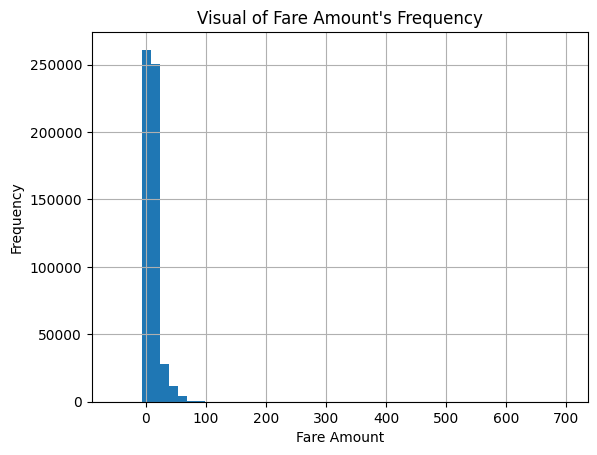

In [3]:
from pyspark.sql.functions import col, sum

# Hitung jumlah data kosong untuk setiap kolom
print("=== Jumlah Nilai Null Dalam Data ===")
train_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_df.columns]).show()

# Statistik umum untuk setiap kolom
print("=== Describe Train Data ===")
train_df.describe().show()

# Distribusi fare_amount
print("=== Data Distribusi fare_amount ===")
train_df.select("fare_amount").describe().show()

# Jumlah penumpang
print("=== Data Jumlah Penumpang ===")
train_df.groupBy("passenger_count").count().show()

# Visualisasi menggunakan matplotlib/seaborn
import matplotlib.pyplot as plt
train_pandas = train_df.sample(fraction=0.01).toPandas()  # Contoh untuk sampling 1% data
train_pandas['fare_amount'].hist(bins=50)
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Visual of Fare Amount's Frequency")
plt.show()

# 3. Menerapkan transformasi data yang diperlukan (preprocessing). (15 poin)

Penjelasan : Pada tahap ini, dilakukan pembersihan dan transformasi data. Hal ini dilakukan untuk menghindari kesalahan saat melakukan analisis, dengan menghapus baris dengan nilai null dari kolom dropoff_longitude dan dropoff_latitude. Selain itu dilakukan penambahan kolom baru untuk mendapatkan data waktu yang lebih akurat, dengan menambahkan kolom pickup_hour dan pickup_day. Ini dilakukan karena waktu penjemputan mungkin memengaruhi tarif. Selanjutnya dilakukan proses penyaringan data berdasarkan tarif wajar untuk memastikan bahwa model tidak dipengaruhi oleh data yang tidak valid atau suara, hapus baris yang memiliki nilai fare_amount yang tidak masuk akal (di luar rentang 0-500).

In [4]:
from pyspark.sql.functions import *

# Menghapus baris dengan nilai null pada kolom dropoff_longitude dan dropoff_latitude
train_df = train_df.dropna(subset=["dropoff_longitude", "dropoff_latitude"])

# Cek lagi jumlah data kosong untuk setiap kolom
print("=== Jumlah Nilai Null Dalam Data ===")
train_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_df.columns]).show()

# Ekstraksi komponen waktu dari pickup_datetime
train_df = train_df.withColumn("pickup_hour", hour("pickup_datetime"))
train_df = train_df.withColumn("pickup_day", dayofweek("pickup_datetime"))

# Menghapus outlier
train_df = train_df.filter((train_df.fare_amount > 0) & (train_df.fare_amount < 500))

=== Jumlah Nilai Null Dalam Data ===
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                0|               0|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



# 4. Melakukan pemodelan menggunakan algoritma yang sesuai dengan PySpark MLlib. (25 poin)

Penjelasan:
Proses pemodelan dilakukan dengan menggunakan VectorAssembler untuk menggabungkan fitur-fitur yang dipilih menjadi satu vektor. Ini memudahkan input untuk model PySpark MLlib. Selanjutnya, data dibagi menjadi data train dan data test untuk evaluasi. Karena masalah regresi ini, fare_amount diprediksi menggunakan algoritma linear regresi. Data train kemudian digunakan untuk melatih model.

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

feature_columns = [
    "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude", 
    "passenger_count", "pickup_hour", "pickup_day"
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="skip"  # Mengabaikan baris yang mengandung nilai null
)

# Menggabungkan kolom fitur menjadi satu vektor
train_df = assembler.transform(train_df)

# Membagi data menjadi data latih dan data uji
train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=42)

# Membuat model regresi linear
lr = LinearRegression(featuresCol="features", labelCol="fare_amount")

# Melatih model
lr_model = lr.fit(train_data)

# 5. Mengevaluasi model yang dihasilkan menggunakan metrik evaluasi yang sesuai. (15 poin)

Penjelasan:
Untuk mengevaluasi model yang telah dibuat, metrik yang dikenal sebagai Root Mean Squared Error (RMSE) digunakan pada tahap ini. Nilai RMSE yang lebih rendah menunjukkan prediksi yang lebih akurat. Hasilnya, model menghasilkan nilai RMSE sebesar 9,76 pada data test, yang menunjukkan kesalahan prediksi rata-rata sebesar 9,76 dolar.

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluasi menggunakan RMSE
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse}")

Root Mean Squared Error (RMSE) on validation data: 9.762479004582415


# 6. Melakukan tuning hyperparameter untuk meningkatkan performa model (10 poin)

Penjelasan:
<ul>
    <li>Menyiapkan grid parameter untuk melakukan tuning <code>regParam</code> dan <code>elasticNetParam</code>.</li>
    <li>Menggunakan cross-validation untuk menemukan konfigurasi model terbaik berdasarkan parameter yang diuji.</li>
    <li>Menampilkan RMSE dari model terbaik dan menampilkan nilai optimal dari hyperparameter yang dipilih.</li>
</ul>

In [7]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Membuat grid parameter untuk hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Menggunakan CrossValidator untuk melakukan tuning hyperparameter
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5  # Cross-validation dengan 5 lipatan
)

# Melakukan cross-validation untuk mendapatkan model terbaik
cv_model = crossval.fit(train_data)

# Melakukan prediksi menggunakan model terbaik pada data uji
best_model_predictions = cv_model.bestModel.transform(test_data)

# Evaluasi model terbaik
best_rmse = evaluator.evaluate(best_model_predictions)
print(f"Best Root Mean Squared Error (RMSE) on validation data: {best_rmse}")

# Menampilkan hyperparameter terbaik
best_model = cv_model.bestModel
print(f"Best Model's regularization parameter (regParam): {best_model._java_obj.getRegParam()}")
print(f"Best Model's ElasticNet parameter (elasticNetParam): {best_model._java_obj.getElasticNetParam()}")

Best Root Mean Squared Error (RMSE) on validation data: 9.762479052665853
Best Model's regularization parameter (regParam): 0.01
Best Model's ElasticNet parameter (elasticNetParam): 0.0


# 7. Kesimpulan

Alur penuh untuk memprediksi tarif taksi NYC menggunakan PySpark MLlib ditunjukkan dalam mengerjakan tugas ini. Pra-pemrosesan data mencakup penghapusan outlier, rekayasa fitur tambahan dari waktu penjemputan, dan pembersihan nilai null. Menggunakan cross-validation, pelatihan model-linear regression, mengevaluasi, dan meningkatkannya dengan mengatur hyperparameter. RMSE awal model adalah 9,76 dan tetap hampir sama setelah tuning, menunjukkan bahwa ada kemungkinan untuk mengeksplorasi fitur tambahan atau model lain untuk meningkatkan akurasi.